# Detecting change in urban extent <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background

The rate at which cities and towns grow, or the urbanisation rate, is an important indicator of the sustainability of towns and cities. Rapid, unplanned urbanisation can result in poor social, economic, and environmental outcomes due to inadequate and overburdened infrastructure and services creating congestion, worsening air pollution, and leading to a shortage of adequate housing.

The first requirement for addressing the impacts of rapid urbanisation is to accurately and regularly monitor urban expansion in order to track urban development over time. Earth Observation datasets, such as those available through the Digital Earth Africa platform provide a cost-effective and accurate means of mapping the urban extent of cities.  


## Description

This notebook will use Landsat satellite images to examine the change in urban extent between a baseline period and a more recent period.  The difference in urban extent (area is square kilometres) between the two periods is calculated, along with a map highlighting the location of urban growth hotspots.

This notebook conducts the following analysis:

1. Load Landsat 8 data over the city/region of interest
2. Generate geomedian composites for the baseline and more recent year.
3. Calculate the Enhanced Normalised Difference Impervious Surfaces Index (ENDISI)
4. Threshold the ENDISI plots to delineate urban extent
5. Compare the urban extent in the baseline year to the more recent urban extent

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_geomedian
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

sys.path.append('../Scripts')
from deafrica_dask import create_local_dask_cluster
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from deafrica_datahandling import load_ard

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35013 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:40523 Dashboard: /user/nanaboamah/proxy/35013/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='Urbanisation')

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `baseline_year`: The baseline year, to use as the baseline of urbanisation (e.g. `2014`)
* `analysis_year`: The analysis year to analyse the change in urbanisation (e.g. `2019`)

In [4]:
# Alter the lat and lon to suit your study area
lat, lon = -1.292, 36.820

# Provide your area of extent here
buffer = 0.4

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Change the years values also here
# Note: Landsat 8 starts from 2013
baseline_year = 2015
analysis_year = 2019

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(lon_range, lat_range)

## Load cloud-masked Sentinel-2 data

The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 

The code below uses the `load_ard` function to load in data from the Landsat 8 satellite for the area and time specified. For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [6]:
# Create a query
query = {
    'time': (f'{baseline_year}', f'{analysis_year}'),
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'measurements':['swir1','swir2','blue','green','red'],
    'group_by': 'solar_day',
    
}

# Create a dataset of the requested data 
ds = load_ard(
    dc=dc, 
    products=['ls8_usgs_sr_scene'],
    output_crs='EPSG:6933',
    dask_chunks={'time': 1, 'x': 750, 'y': 750},
    **query
)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 226 time steps as a dask array


## Calculate the geomedian for each year

Here we group the timeseries into years and calculate the geomedian (geometric median) for each year.

For more information about computing geomedians, see the [Generating Geomedian Composites](../Frequently_used_code/Generating_geomedian_composites.ipynb) notebook.

In [7]:
# groupby year, then calculate the geomedian on each year
geomedians = ds.groupby('time.year').map(xr_geomedian)
print(geomedians)

<xarray.Dataset>
Dimensions:  (x: 2574, y: 3402, year: 5)
Coordinates:
  * y        (y) float64 -1.138e+05 -1.138e+05 ... -2.158e+05 -2.158e+05
  * x        (x) float64 3.514e+06 3.514e+06 3.514e+06 ... 3.591e+06 3.591e+06
  * year     (year) int64 2015 2016 2017 2018 2019
Data variables:
    swir1    (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    swir2    (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    blue     (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    green    (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    red      (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>


We can see now that the `time` dimension has been replaced by the `year` dimension. Since the query was for all data between our target years, we have data for all years in the range.  Since we are only looking at 2 years, we will just select those.

>**Note:** As we are using `dask`, no data reading or calculations have yet taken place.

In [8]:
geomedians = geomedians.sel(year=[baseline_year, analysis_year])
print(geomedians)

<xarray.Dataset>
Dimensions:  (x: 2574, y: 3402, year: 2)
Coordinates:
  * y        (y) float64 -1.138e+05 -1.138e+05 ... -2.158e+05 -2.158e+05
  * x        (x) float64 3.514e+06 3.514e+06 3.514e+06 ... 3.591e+06 3.591e+06
  * year     (year) int64 2015 2019
Data variables:
    swir1    (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    swir2    (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    blue     (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    green    (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    red      (year, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>


### Load the data and calculate the geomedian for the selected years

Now that we have the geomedians for the 2 years we want to analyse, we can trigger the delay-loading and calculation.

This will use the `dask` cluster we set up earlier. You can follow the progress of this step by opening the Dask processing window. See the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb). 

In [9]:
%%time
geomedians = geomedians.compute()

CPU times: user 6min 48s, sys: 10.5 s, total: 6min 58s
Wall time: 53min 46s


## View the satellite data
We can plot the two years to visually compare them:

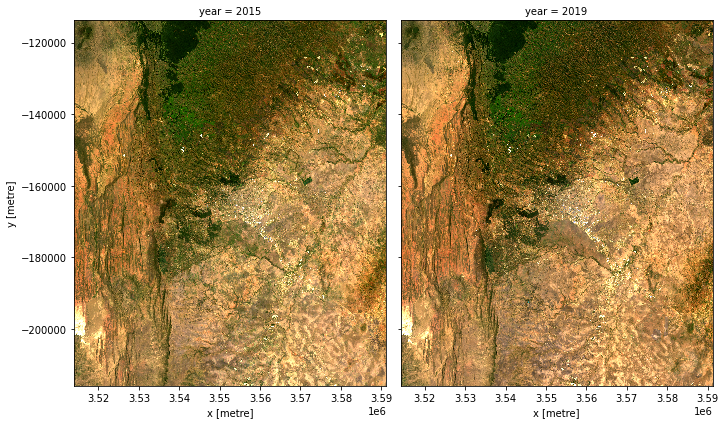

In [10]:
rgb(geomedians, col='year')

## Calculate ENDISI

The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a recently developed urbanisation proxy that has been shown to work well in a variety of environments ([Chen et al. 2020](https://www.tandfonline.com/doi/full/10.1080/22797254.2020.1820383)) . Like all normalised difference indicies, it has a range of \[-1,1\].
Note that `MNDWI`, `swir_diff` and `alpha` are all part of the ENDISI calculation.

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}}
\end{aligned}
$$

$$
\begin{aligned}
\text{swir_diff} = \frac{\text{SWIR1}}{\text{SWIR2}}
\end{aligned}
$$

$$
\begin{aligned}
\text{alpha} = \frac{2 * \text{mean(BLUE)}}{\text{mean(swir_diff) + mean(MNDWI}^2)}
\end{aligned}
$$

$$
\begin{aligned}
\text{ENDISI} = \frac{\text{BLUE} - \text{alpha}*(\text{swir_diff} + \text{MNDWI}^2)}
{\text{BLUE} + \text{alpha}*(\text{swir_diff} + \text{MNDWI}^2)}
\end{aligned}
$$

In [11]:
def MNDWI(dataset):
    return calculate_indices(dataset, index='MNDWI', collection='c1').MNDWI

def Swir_diff(dataset):
    return dataset.swir1/dataset.swir2

def Alpha(dataset):
    return (2*(np.mean(dataset.blue)))/(np.mean(Swir_diff(dataset)) + np.mean(MNDWI(dataset)**2))

def ENDISI(dataset):
    mndwi = MNDWI(dataset)
    swir_diff = Swir_diff(dataset)
    alpha = Alpha(dataset)
    return (dataset.blue - (alpha)*(swir_diff + mndwi**2))/(dataset.blue + (alpha)*(swir_diff + mndwi**2))

In [12]:
# Calculate the ENDISI index
geomedians['ENDISI'] = ENDISI(geomedians)

Let's plot the ENDISI images so we can see if the urban areas are distinguishable

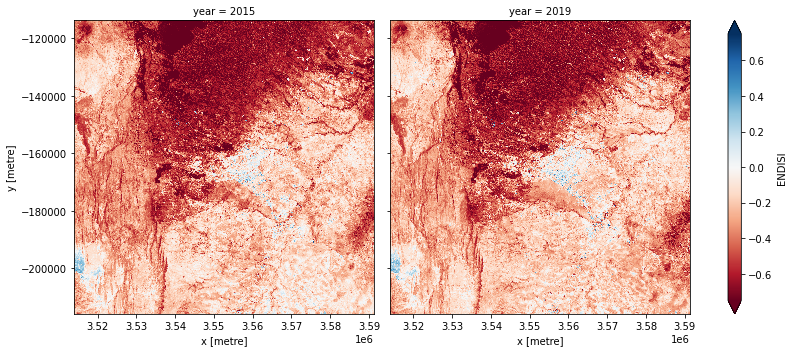

In [13]:
geomedians.ENDISI.plot(
    col='year',
    vmin=-.75, 
    vmax=0.75, 
    cmap='RdBu',
    figsize=(12, 5),
    robust=True
);

And now plot the histogram of all the pixels in the ENDISI array

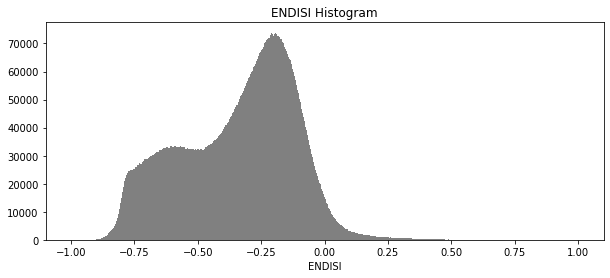

In [14]:
geomedians.ENDISI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('ENDISI Histogram');

## Calculate urban extent

To define the urban extent, we need to threshold the ENDISI arrays. Values above this threshold will be labelled as 'Urban' while values below the trhehsold will be excluded from the urban extent.  We can determine this threshold a number of ways (inluding by simply manually definining it e.g. `threshold=-0.1`).  Below, we use the [Otsu method](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html) to automatically threshold the image.  

Firstly, we need to fill any `NaN` values we have in the dataset with the mean of the dataset, otherwise the otsu threshold function will complain:

In [15]:
geomedians['ENDISI'] = geomedians.ENDISI.fillna(geomedians.ENDISI.mean().values)

In [16]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(geomedians.ENDISI.values)
print(round(threshold, 2))

-0.4


### Apply the threshold

We apply the threshold and plot both years side-by-side.

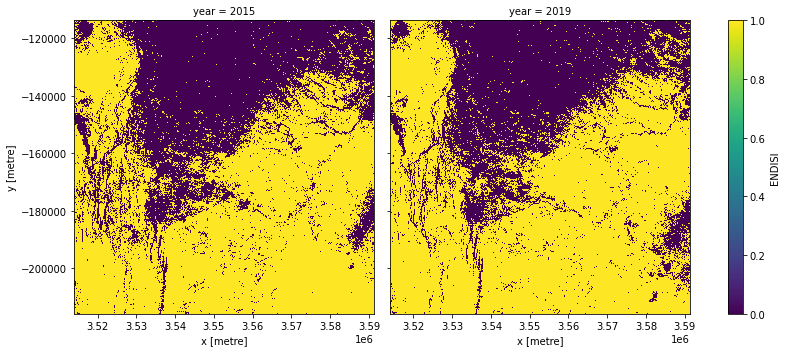

In [17]:
urban_area = (geomedians.ENDISI > threshold).astype(int)
urban_area.plot(
    col='year',
    figsize=(12, 5),
    robust=True
);

## Plotting the change in urban extent
We can convert the data above into a total area for each year, then plot a bar graph.

Urban extent in 2015: 4863.4614 km2
Urban extent in 2019: 5066.5338 km2


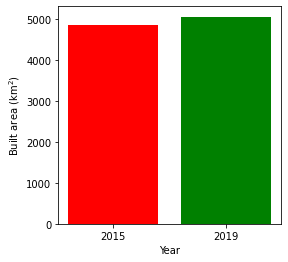

In [18]:
pixel_length = query["resolution"][1]  # in metres
area_per_pixel = pixel_length**2 / 1000**2

urban_area_km2 = urban_area.sum(dim=['x', 'y']) * area_per_pixel

# Plot the resulting area through time
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.bar([0, 1], 
        urban_area_km2, 
        tick_label = urban_area_km2.year, 
        width = 0.8, 
        color = ['red', 'green'])
axes.set_xlabel("Year")
axes.set_ylabel("Built area (km$^2$)");
print('Urban extent in '+str(baseline_year)+': '+str(urban_area_km2.sel(year=baseline_year).values)+' km2')
print('Urban extent in '+str(analysis_year)+': '+str(urban_area_km2.sel(year=analysis_year).values)+' km2')

## Urban growth hotspots

If we subtract the ENDISI of the baseline year from the analysis year, we can highlight regions where urban growth is occurring. To ensure we aren't capturing *all* change, we can set a change threshold, beyond which we distinguish between real change from background variation.

In this plot, we can see areas that have seen significant change, highlighting regions of urbanisation.

In [19]:
change_threshold = 0.15

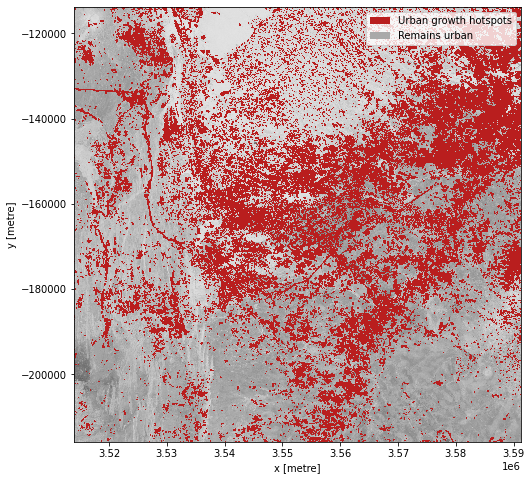

In [20]:
# Calculate the change in BU between the years
urban_change = geomedians.ENDISI.sel(
    year=analysis_year) - geomedians.ENDISI.sel(year=baseline_year)

# Plot urban extent from first year in grey as a background
baseline_urban = xr.where(urban_area.sel(year=baseline_year), 1, np.nan)
plot = geomedians.ENDISI.sel(year=baseline_year).plot(cmap='Greys',
                                                      size=8,
                                                      aspect=urban_area.y.size /
                                                      urban_area.y.size,
                                                      add_colorbar=False)

# Plot the meaningful change in urban area
# Colours from https://colorbrewer2.org/?type=diverging&scheme=PiYG&n=3
to_urban = '#b91e1e'
xr.where(urban_change > change_threshold, 1,
         np.nan).plot(ax=plot.axes,
                      add_colorbar=False,
                      cmap=ListedColormap([to_urban]))

# Add the legend
plot.axes.legend(
    [
        Patch(facecolor=to_urban),
        Patch(facecolor='darkgrey'),
        Patch(facecolor='white')
    ],
    ['Urban growth hotspots', 'Remains urban'],
);

## Next steps

When you are done, return to the [Analysis parameters](#Analysis-parameters) section, modify some values (e.g. `lat`, `lon` or `time`) and rerun the analysis.

You can use the interactive map in the [View the selected location](#View-the-selected-location) section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Landsat 8 data is available for the new location, which you can check at the [Digital Earth Africa Explorer](https://explorer.digitalearth.africa/ls8_usgs_sr_scene).


For more advanced methods of urban extent detection, see the [Machine Learning with ODC](../Real_world_examples/Machine_learning_with_ODC.ipynb) notebook, which uses a decision tree to classify urban area. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)